In [5]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import precision_score
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
from skimage.filters import threshold_otsu
similarity_case_1_p = '../../../results/RF/simliarity_measure/case_1_ref_mask_similarity_measure.tif'
similarity_case_2_p = '../../../results/RF/simliarity_measure/case_2_ref_mask_similarity_measure.tif'
similarity_case_3_p = '../../../results/RF/simliarity_measure/case_3_ref_mask_similarity_measure.tif'

gt_source_path  = '../../../data/rasterized_samples/2018_rasterizedImage.tif'
gt_target_path = '../../../data/rasterized_samples/2019_rasterizedImage.tif'

In [8]:
with rasterio.open(similarity_case_1_p) as src:
    similarity_array = src.read(1)
    profile = src.profile
    profile['nodata'] = 0.0
    
gt_source_ = rasterio.open(gt_source_path).read(1)
gt_target_ = rasterio.open(gt_target_path).read(1)

# get gt mask (where there are value) and binary (change/no-chnage)
gt_mask = (gt_source_ != 0) & (gt_target_ != 0)
gt_binary = np.where(gt_mask, np.where(gt_source_ == gt_target_, 1, 2), 0) # gt change/no-change
gt_binary_mask = np.ma.masked_array(gt_binary, mask=True)
gt_binary_mask.mask[gt_binary_mask.data != 0] = False # mask all non-zero mask
gt_binary_ = gt_binary_mask.compressed() # gt_binary with nodata value (0)
gt_binary_[gt_binary_ == 1] = 0 # No-change
gt_binary_[gt_binary_ == 2] = 1 # Change
    
# mask similarity map 
similarity_mask = np.ma.masked_array(similarity_array, mask= True)
similarity_mask.mask[gt_binary_mask.data != 0] = False # extract according to the non-zero from ground truth data
similarity_ = similarity_mask.compressed()
threshold = threshold_otsu(similarity_)
otsu_binary = similarity_ > threshold

fscore = f1_score(gt_binary_, otsu_binary)

In [9]:
fscore

0.9781685350118365

In [1]:
# plt.figure(figsize=(18,10))
# plt.imshow(binary)
# plt.show()

In [ ]:
# groud truth binary
gt_mask_nodata = (gt_source != 0) & (gt_target != 0)
gt_binary = np.where(gt_mask_nodata, np.where(gt_source == gt_target, 1, 2), 0) # reference binary change 
gt_binary_mask = np.ma.masked_array(gt_binary, mask=True) # returns all true mask
gt_binary_mask.mask[gt_binary_mask.data != 0] = False # mask all non-zero mask
gt_binary_= gt_binary_mask.compressed()
gt_binary_[gt_binary_== 1] = 0 # No-change
gt_binary_[gt_binary_== 2] = 1 # Change

In [ ]:
print(gt_binary.max())
print(gt_binary.min())
print(np.unique(gt_binary))
print(np.unique(gt_binary_))

2
0
[0 1 2]
[0 1]


In [ ]:
similarity_mask = np.ma.masked_array(similarity_array, mask= True)
similarity_mask.mask[gt_binary_mask.data != 0] = False # extract according to the non-zero from ground truth data
similarity_ = similarity_mask.compressed()

In [ ]:
print(similarity_.min())
print(similarity_.max())

0.0
1.4130859


In [ ]:
# get equal threshold for similarity
thresholds = np.linspace(similarity_.min(), similarity_.max(), 10)
thresholds

array([0.        , 0.15700955, 0.3140191 , 0.47102865, 0.62803819,
       0.78504774, 0.94205729, 1.09906684, 1.25607639, 1.41308594])

In [ ]:
# initiate metrics
fscore_ = np.zeros(shape=(len(thresholds)))
precision_ = np.zeros(shape=(len(thresholds)))
recall_ = np.zeros(shape=(len(thresholds)))
specificity_ = np.zeros(shape=(len(thresholds)))
sensitivity_ = np.zeros(shape=(len(thresholds)))
avg_pre = np.zeros(shape=(len(thresholds)))
fpr = []
tpr = []

In [ ]:
# compute metrics for each threshold, at the same time compute the binary on the similarity using the provided threshold
    # np.where(similarity_ >= elem, 1, 0) # where similarity measure (euclidean distance) is greater than threshold == 1 otherwise 0.
for index, elem in enumerate(thresholds):
    fscore_[index] = f1_score(gt_binary_, np.where(similarity_ >= elem, 1, 0))
    precision_[index] = precision_score(gt_binary_, np.where(similarity_ >= elem, 1, 0))
    recall_[index] = recall_score(gt_binary_, np.where(similarity_ >= elem, 1, 0))
    # avg_pre[index] = average_precision_score(gt_binary_, np.where(similarity_ >= elem, 1, 0))
    cm = confusion_matrix(gt_binary_, np.where(similarity_ >= elem, 1, 0)) # confusion matrix
    # # specificity_[index] = cm[1,1] / (cm[1,0] + cm[1,1])
    # # sensitivity_[index] = cm[0,0] / (cm[0,0] + cm[0,1]) # the same a recall
    fpr.append(np.float16(cm[0,1]/(cm[0,1] + cm[1,1]))) # fp / (fp+tn)
    tpr.append(np.float16(cm[0,0]/(cm[0,0] + cm[1,0]))) # tp / (tp + fn)

# https://stackoverflow.com/questions/34709576/runtimewarning-invalid-value-encountered-in-long-scalars
# to get rid of the warning

/tmp/ipykernel_39043/313180606.py:12: RuntimeWarning: invalid value encountered in long_scalars
  tpr.append(np.float16(cm[0,0]/(cm[0,0] + cm[1,0]))) # tp / (tp + fn)


In [ ]:
opt_threshold_idx = np.argmax(fscore_)
opt_threshold = thresholds[opt_threshold_idx]
opt_threshold

0.7850477430555556

In [ ]:
similarity_binary = np.where(similarity_ >= opt_threshold, 2, 1)
similarity_binary_change = np.empty_like(gt_binary)
# similarity_binary_change[similarity_ == 0] = 1
# similarity_binary_change[similarity_ == 1] = 2
similarity_binary_change[~gt_binary_mask.mask] = similarity_binary.ravel()

# with rasterio.open('test_similarity.tif', 'w', **profile) as dst:
#     dst.write(similarity_binary_change, 1)

In [ ]:
change_array = np.empty_like(gt_binary_) # flatten shape
change_array[(gt_binary_== 0) & (similarity_binary == 1)] = 1
change_array[(gt_binary_== 0) & (similarity_binary == 2)] = 2
change_array[(gt_binary_== 1) & (similarity_binary == 1)] = 3
change_array[(gt_binary_== 1) & (similarity_binary == 2)] = 4

In [ ]:
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4900020.0), 'tiled': False, 'interleave': 'band'}

In [ ]:
change_map = np.empty_like(gt_binary)
change_map[~gt_binary_mask.mask] = change_array.ravel()

In [ ]:
print(np.unique(change_array))
print(np.unique(change_map))

[1 2 3 4]
[0 1 2 3 4]


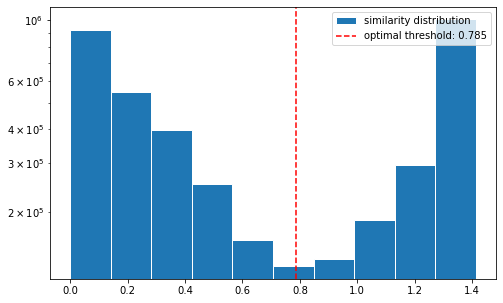

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(similarity_, bins=10, label='similarity distribution',  ec='white', log=True)
plt.axvline(x=thresholds[opt_threshold_idx], color='r', linestyle='--', label="optimal threshold: {0:0.3f}".format(thresholds[opt_threshold_idx]))
plt.legend()
plt.show()

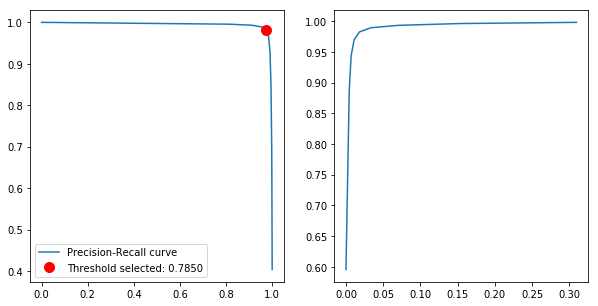

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].plot(opt_threshold_)
ax[0].plot(recall_, precision_, label='Precision-Recall curve')
ax[0].plot(recall_[opt_threshold_index], precision_[opt_threshold_index], 'o', markersize=10, color='r', label='Threshold selected: {0:0.4f}'.format(opt_threshold_))
ax[1].plot(fpr, tpr, label='ROC_curve')
ax[0].legend()
plt.show()
# ax[1].xlim([0.0,1.0])
# ax[0].plot(thresholds, recall_, label='Recall')

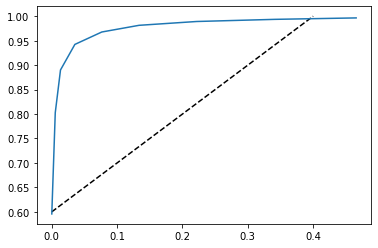

In [ ]:
plt.figure()
# plt.plot([0,0.4],[0.6,1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.plot(fpr, tpr)

In [ ]:
# F1 score table
df = pd.DataFrame({'threshold': thresholds, 'fscore': fscore_, 'precision': precision_, 'recall': recall_, 'specificity': specificity_})
# df_f1 = pd.DataFrame({'threshold': thresholds, 'fscore':fscore_})
# df_f1
df

,threshold,fscore,precision,recall,specificity
0,0.000000,0.575761,0.404259,1.000000,0.0
1,0.157010,0.816063,0.690158,0.998155,0.0
2,0.314019,0.915390,0.847676,0.994860,0.0
3,0.471029,0.959120,0.929693,0.990471,0.0
4,0.628038,0.975272,0.966580,0.984121,0.0
5,0.785048,0.978049,0.981952,0.974176,0.0
6,0.942057,0.971360,0.989059,0.954282,0.0
7,1.099067,0.950937,0.993073,0.912231,0.0
8,1.256076,0.896287,0.995579,0.815004,0.0
9,1.413086,0.000440,1.000000,0.000220,0.0


In [15]:
# ROC curve
# plt.figure()
# for index, elem in enumerate(thresholds):
#     plt.plot(fpr[index], tpr[index], label='Threshold: {0}'.format(elem))
# plt.plot([0, 1], [0, 1], 'k--')
# # plt.xlim([0.0, 1.0])
# # plt.ylim([0.0, 1.05])
# plt.legend()
# plt.show()